In [1]:
import rebound
import numpy as np
import pandas as pd
import dask.dataframe as dd
from collections import OrderedDict
from celmech.poincare import Poincare, PoincareHamiltonian
from celmech import Andoyer, AndoyerHamiltonian
from celmech.resonances import resonant_period_ratios, resonance_intersections_list, resonance_pratio_span
from celmech.transformations import masses_to_jacobi
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

Are initially closest Zcross planets always the ones that collide?


In [25]:
path = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/stabilitydataset/'
TTVpath = 'data/TTVsystems/KOI-0314/simulation_archives/runs/sa'
respath = 'data/resonant/simulation_archives/runs/sa'

In [26]:
df = pd.read_csv(path+'../MLstability/training_data/resonant/inputresonantparams.csv', index_col=0)
df.head()

,runstring,seed,pairindex,j,k,Zstar,libfac,Zcom
0,0000000.bin,3500000,1,12,1,0.021650,0.007181,0.041669
1,0000001.bin,700001,1,19,2,0.060291,0.523204,0.010656
2,0000002.bin,2,0,6,1,0.026353,0.012995,0.050319
3,0000003.bin,2100003,0,5,2,0.023511,0.713415,0.102200
4,0000004.bin,700004,0,12,1,0.017473,0.003612,0.039803


In [27]:
def findres2(sim, i1, i2):
    maxorder = 2
    ps = Poincare.from_Simulation(sim=sim).particles # get averaged mean motions
    n1 = ps[i1].n
    n2 = ps[i2].n

    m1 = ps[i1].m/ps[i1].M
    m2 = ps[i2].m/ps[i2].M

    Pratio = n2/n1
    if np.isnan(Pratio): # probably due to close encounter where averaging step doesn't converge 
        return np.nan, np.nan, np.nan

    delta = 0.03
    minperiodratio = max(Pratio-delta, 0.)
    maxperiodratio = min(Pratio+delta, 0.999) # too many resonances close to 1
    res = resonant_period_ratios(minperiodratio,maxperiodratio, order=2)
    
    Z = np.sqrt((ps[i1].e*np.cos(ps[i1].pomega) - ps[i2].e*np.cos(ps[i2].pomega))**2 + (ps[i1].e*np.sin(ps[i1].pomega) - ps[i2].e*np.sin(ps[i2].pomega))**2)
    Zcross = (ps[i2].a-ps[i1].a)/ps[i1].a
        
    j, k, i1, i2, maxstrength = -1, -1, -1, -1, -1
    for a, b in res:
        s = np.abs(np.sqrt(m1+m2)*(Z/Zcross)**((b-a)/2.)/((b*n2 - a*n1)/n1))
        #print('{0}:{1}'.format(b, a), (b*n2 - a*n1), s)
        if s > maxstrength:
            j = b
            k = b-a
            maxstrength = s

    return j, k, maxstrength

In [34]:
def testwhichcollide(row, unstable=[], Zcross=[], emZc=[], beta=[], strengths=[], col13=[]):
    try:
        sa = rebound.SimulationArchive(path+respath+row['runstring'])
    except:
        print(path+respath+row['runstring'])
        return unstable, Zcross, emZc, beta, strengths, col13

    ID = row.name
    simf = sa[-1]
    tinst = simf.t
    if tinst > 9.98e8:
        return unstable, Zcross, emZc, beta, strengths, col13
    else:
        unstable.append(ID)
      
    N = simf.N
    ps = simf.particles
    mindRH = 100.
    for i, [i1, i2] in enumerate(itertools.combinations(np.arange(1, N), 2)):
        i1 = int(i1)
        i2 = int(i2)
        d = np.sqrt((ps[i1].x-ps[i2].x)**2 + (ps[i1].y-ps[i2].y)**2 + (ps[i1].z-ps[i2].z)**2)
        RH = ps[i1].a*((ps[i1].m + ps[i2].m)/ps[0].m)**(1./3.)
        if d/RH < mindRH:
            dRHi = [i1, i2] # two indices that collided
            mindRH = d/RH
    #print(ID, dRHi)
         
    sim = sa[0]
    
    if dRHi == [1,3]:
        #print(ID, np.log10(simf.t), sim.particles[3].P/sim.particles[1].P)
        col13.append(ID)
   
    #Zc, RH, beta, eZcs = np.zeros(3), np.zeros(3), np.zeros(3), np.zeros(3)
    N = sim.N
    ps = sim.particles
    
    minZcross = 1.
    maxemZc = 0.
    minbeta = 20.
    maxstrength = 0.
    strengthi = [0,0]
    for i, [i1, i2] in enumerate(itertools.combinations(np.arange(1, N), 2)):
        i1 = int(i1)
        i2 = int(i2)
        j, k, strength = findres2(sim, i1, i2) # max strength between i1 and i2
        Zc = (ps[i2].a-ps[i1].a)/ps[i1].a
        RH = ps[i1].a*((ps[i1].m + ps[i2].m)/ps[0].m)**(1./3.)
        b = (ps[i2].a-ps[i1].a)/RH
        eZc = np.sqrt((ps[i2].e*np.cos(ps[i2].pomega)-ps[i1].e*np.cos(ps[i1].pomega))**2 + (ps[i2].e*np.sin(ps[i2].pomega)-ps[i1].e*np.sin(ps[i1].pomega))**2)/Zc
        if Zc < minZcross:
            Zcrossi = [i1, i2]
            minZcross = Zc
        if eZc > maxemZc:
            emZci = [i1, i2]
            maxemZc = eZc
        if b < minbeta:
            betai = [i1, i2]
            minbeta = b
        if strength > maxstrength:
            strengthi = [i1, i2]
            maxstrength = strength
        #print(i1, i2, Zc, eZc, beta, strength)
    #print(Zcrossi, emZci, betai)
    
    if Zcrossi == dRHi:
        Zcross.append(ID)
    if emZci == dRHi:
        emZc.append(ID)
    if betai == dRHi:
        beta.append(ID)
    if strengthi == dRHi:
        strengths.append(ID)
    return unstable, Zcross, emZc, beta, strengths, col13

# Print out ID, log inst time and Period ratio of 1 and 3 in systems where non-adjacent planets collide (1 and 3)

In [35]:
Nsystems = 10000
unstable = []
Zcross = []
emZc = []
beta = []
strengths = []
col13 = []
for i, row in df.iterrows():
    unstable, Zcross, emZc, beta, strengths, col13 = testwhichcollide(row, unstable, Zcross, emZc, beta, strengths, col13)

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/stabilitydataset/data/resonant/simulation_archives/runs/sa0002058.bin


# Best predictor of which pair will collide is what pair initially has the smallest Zcross, but only gets its right 75\% of the time

In [36]:
Nunstable = len(unstable)
print('Fraction whose pair of colliding planets were the pair with smallest Zcross initially:', len(Zcross)/Nunstable)
print('Fraction whose pair of colliding planets were the pair with largest Z/Zcross initially:', len(emZc)/Nunstable)
print('Fraction whose pair of colliding planets were the pair with smallest mutual Hill radius separation initially:', len(beta)/Nunstable)
print('Fraction whose pair of colliding planets were the pair with strongest resonance initially:', len(strengths)/Nunstable)

Fraction whose pair of colliding planets were the pair with smallest Zcross initially: 0.7436486486486487
Fraction whose pair of colliding planets were the pair with largest Z/Zcross initially: 0.6733783783783783
Fraction whose pair of colliding planets were the pair with smallest mutual Hill radius separation initially: 0.6543243243243243
Fraction whose pair of colliding planets were the pair with strongest resonance initially: 0.5632432432432433


# In 1\% of cases, the non-adjacent planets collided

In [37]:
print('Fraction whose pair of colliding planets were not adjacent (1 and 3)', len(col13)/Nunstable)

Fraction whose pair of colliding planets were not adjacent (1 and 3) 0.008243243243243244


# Of those 61 cases, only 3 were ones where 1 and 3 were the ones initialized in resonance

In [40]:
(df.loc[col13]['pairindex'] == 2).sum()

3

# Is the reason that max strength is not a good predictor of which planets cross because many systems were set up with resonance between 1 and 3?

No, see below

# Only 614/10000 = 6\% are set up with resonance between 1 and 3

pairindex = 2 means resonance between 1 and 3

In [41]:
(df['pairindex'] == 2).sum()

614

# Excluding systems set up with res between 1 and 3 improves maxstrength's ability to predict which pair collides, as expected, but only slightly. 

# Means we have many systems where a strong resonance protects that pair,  and it's the third planet that suffers the collision

In [43]:
Nsystems = 10000
unstable = []
Zcross = []
emZc = []
beta = []
strengths = []
col13 = []
for i, row in df.iterrows():
    if row['pairindex'] == 2:
        continue
    unstable, Zcross, emZc, beta, strengths, col13 = testwhichcollide(row, unstable, Zcross, emZc, beta, strengths, col13)

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/stabilitydataset/data/resonant/simulation_archives/runs/sa0002058.bin


In [45]:
Nunstable = len(unstable)
print('Fraction whose pair of colliding planets were the pair with smallest Zcross initially:', len(Zcross)/Nunstable)
print('Fraction whose pair of colliding planets were the pair with largest Z/Zcross initially:', len(emZc)/Nunstable)
print('Fraction whose pair of colliding planets were the pair with smallest mutual Hill radius separation initially:', len(beta)/Nunstable)
print('Fraction whose pair of colliding planets were the pair with strongest resonance initially:', len(strengths)/Nunstable)

Fraction whose pair of colliding planets were the pair with smallest Zcross initially: 0.7467172454041435
Fraction whose pair of colliding planets were the pair with largest Z/Zcross initially: 0.6692442369419317
Fraction whose pair of colliding planets were the pair with smallest mutual Hill radius separation initially: 0.664283629997082
Fraction whose pair of colliding planets were the pair with strongest resonance initially: 0.6025678435949811


# Good example of a system where closest Hill radius pair near a strong resonance is not the pair that collides

In [96]:
sa = rebound.SimulationArchive(path+respath+'0000018.bin')
tmax = sa[1].t
sim = sa[0]

P12 = []
P23 = []
ts = []
print(sa[-1].t)
for sim in sa:
    ps = sim.particles
    P12.append(ps[2].P/ps[1].P)
    P23.append(ps[3].P/ps[2].P)
    ts.append(sim.t)

98716780.65077779


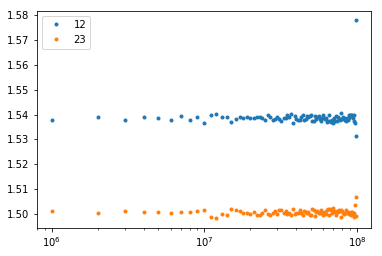

In [98]:
fig, ax = plt.subplots()
ax.plot(ts, P12, '.', label='12')
ax.plot(ts, P23, '.', label='23')
ax.set_xscale('log')
ax.legend()

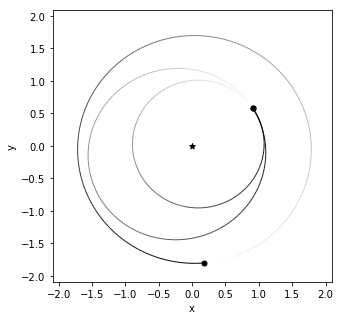

In [116]:
fig = rebound.OrbitPlot(sa[99])

In [12]:
testwhichcollide(18)

98716780.65077779
98716780.65077779


(1, 0, 1, 0, 0, 0)

# Example of 1 and 3 colliding, after 8.93e8 orbits!

In [147]:
sa = rebound.SimulationArchive(path+respath+'0000861.bin')
tmax = sa[1].t
sim = sa[0]

P12 = []
P23 = []
P13 = []
ts = []
print(sa[-1].t)
for sim in sa:
    ps = sim.particles
    P12.append(ps[2].P/ps[1].P)
    P23.append(ps[3].P/ps[2].P)
    P13.append(ps[3].P/ps[1].P)
    ts.append(sim.t)

864265896.1094736


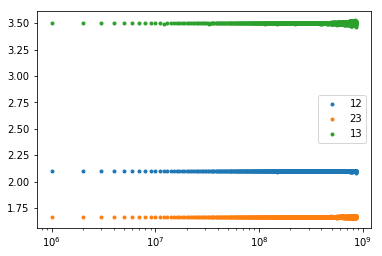

In [148]:
fig, ax = plt.subplots()
ax.plot(ts, P12, '.', label='12')
ax.plot(ts, P23, '.', label='23')
ax.plot(ts, P13, '.', label='13')
ax.set_xscale('log')
ax.legend()

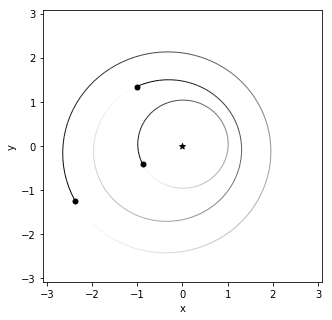

In [149]:
fig = rebound.OrbitPlot(sa[0])

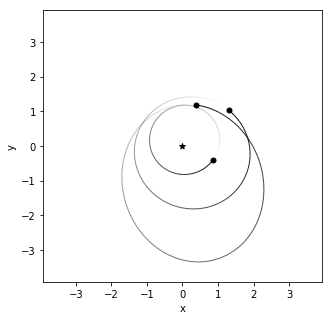

In [155]:
fig = rebound.OrbitPlot(sa[-2])